# Tutorial-3: Spin wave of kagome lattice Heisenberg model with classical spin

In [1]:
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import spintoolkit_py as sptk

## Define a kagome lattice to be used

In [2]:
sptk.print_system_info()
latt = sptk.lattice(name = "kagome", l = [36, 36])

Hostname:                d196575d6e36
CPU Type:                12th Gen Intel(R) Core(TM) i9-12900
Thread count:            16
Platform:                linux
Time Now:                2026-02-03---07:35:12.789---UTC

OMP version:             202011
OMP bind policy:         false
OMP number of procs:     16
OMP number of threads:   1
OMP number of devices:   0

Boost lib version:       1_83
NLopt version:           2.7.1
SPGlib version:          2.3.1
SpinToolkit Compiled by: Clang version 18.1.3 (1ubuntu1) (-O1, -O2, -O3) on Feb  3 2026
SpinToolkit version:     1.6.0

Kagome lattice built.
L       = 3888
num_sub = 3
dim     = 2
Real space basis (a):                              
a0: [                   1                   0]
a1: [                -0.5           0.8660254]
Reciprocal space basis (b / 2π):                   
b0: [                   1           0.5773503]
b1: [                   0            1.154701]
Superlattice real space basis (A) [unit: a]:       
A0: [                

## Define the model and include magnetic couplings

In [3]:
J = 1.0

hamiltonian = sptk.model_spin(S = 1.0, mode = "dipole", lattice = latt)
print()

L = latt.total_sites()
for xi in range(latt.l0()):
    for yi in range(latt.l1()):
        coor_i      = [xi, yi]
        coor0_i, r̃i = latt.r2superlattice(coor = coor_i)
        site_i0     = latt.coor2site(coor = coor_i, sub = 0)
        site_i1     = latt.coor2site(coor = coor_i, sub = 1)
        site_i2     = latt.coor2site(coor = coor_i, sub = 2)

        coor_j      = [xi + 1, yi]
        coor0_j, r̃j = latt.r2superlattice(coor = coor_j)
        site_j2     = latt.coor2site(coor = coor_j, sub = 2)
        hamiltonian.add_2spin_XYZ(J = sptk.Vec3(J, J, J),
                                  site_i = site_i0, site_j = site_j2,
                                  rtilde_i = r̃i, rtilde_j = r̃j)
        hamiltonian.add_2spin_XYZ(J = sptk.Vec3(J, J, J),
                                  site_i = site_i0, site_j = site_i2,
                                  rtilde_i = r̃i, rtilde_j = r̃i)

        coor_j      = [xi, yi + 1]
        coor0_j, r̃j = latt.r2superlattice(coor = coor_j)
        site_j0     = latt.coor2site(coor = coor_j, sub = 0)
        hamiltonian.add_2spin_XYZ(J = sptk.Vec3(J, J, J),
                                  site_i = site_i1, site_j = site_j0,
                                  rtilde_i = r̃i, rtilde_j = r̃j)
        hamiltonian.add_2spin_XYZ(J = sptk.Vec3(J, J, J),
                                  site_i = site_i1, site_j = site_i0,
                                  rtilde_i = r̃i, rtilde_j = r̃i)

        coor_j      = [xi - 1, yi - 1]
        coor0_j, r̃j = latt.r2superlattice(coor = coor_j)
        site_j1     = latt.coor2site(coor = coor_j, sub = 1)
        hamiltonian.add_2spin_XYZ(J = sptk.Vec3(J, J, J),
                                  site_i = site_i2, site_j = site_j1,
                                  rtilde_i = r̃i, rtilde_j = r̃j)
        hamiltonian.add_2spin_XYZ(J = sptk.Vec3(J, J, J),
                                  site_i = site_i2, site_j = site_i1,
                                  rtilde_i = r̃i, rtilde_j = r̃i)

hamiltonian.simplify().build_mc_list()
print()

Model with S=1 (mode = dipole) initialized.

simplifying bond_Jij:               7776     ----->       7776,	 elapsed time: 0.001329018s.
building interaction list for MC... 0.001494043s.
Average coordination (bilinear) per site:     4
Average coordination (biquadratic) per site:  0
Number of onsite anisotropy:                  0
Number of CEF terms:                          0
Number of Zeeman terms:                       0
E_shift/L:                                    0



## Create a folder *dump* for logging the results

In [4]:
dump_dir = "dump"
if os.path.exists(dump_dir):
    shutil.rmtree(dump_dir)
os.makedirs(dump_dir)

with open(os.path.join(dump_dir, "energy.dat"), "w") as foutE:
    foutE.write(f"{'#(1)':>20}{'(2)':>20}\n")
    foutE.write(f"{'time':>20}{'E':>20}\n")
foutE.close()

with open(os.path.join(dump_dir, "total_sites.dat"), "w") as foutL:
    foutL.write(f"{L}\n")
foutL.close()

## Monte Carlo parameters

In [5]:
seed = 0                            # random seed
T    = 0.0005                       # final temperature
T0   = 0.1                          # initial temperature of annealing

max_sweeps      = 400000
sweeps_anneal   = max_sweeps // 4
log_interval    = 100               # frequency of doing measurements
sweeps_per_dump = 40000             # frequency of taking snapshots

alpha_anneal = np.exp(np.log(T / T0) / sweeps_anneal)
if alpha_anneal < 0.5 or alpha_anneal >= 1.0:
    raise ValueError("alpha_anneal should be in the range of [0.5, 1.0)!")

print("Total sweeps:                    ", max_sweeps)
print("Sweeps used for annealing:       ", sweeps_anneal)
print("alpha (T_{n} = alpha * T_{n-1}): ", alpha_anneal)
print("Intervals of logging energy:     ", log_interval, " sweeps")
print("Intervals of taking snapshots:   ", sweeps_per_dump, " sweeps")

Total sweeps:                     400000
Sweeps used for annealing:        100000
alpha (T_{n} = alpha * T_{n-1}):  0.999947018229918
Intervals of logging energy:      100  sweeps
Intervals of taking snapshots:    40000  sweeps


## Perform Monte Carlo (in serious MC, should do a few independent MC's to estimate average and error; here we only perform one MC run for the purpose of demonstration)

In [6]:
mc = sptk.mc_dipole(seed_global = seed, seed_local = 0, Ti = T0, dump_dir = dump_dir)

s = sptk.Vec3List(L)                                   # array of spins
mc.set_random(model = hamiltonian, s = s)              # randomize initial spins

n_sweeps = 0
while n_sweeps < max_sweeps:
    # logging
    if n_sweeps % log_interval == 0:
        with open(os.path.join(mc.dump_dir, "energy.dat"), "a") as foutE:
            foutE.write(f"{n_sweeps:20d}{mc.Energy():20.7e}\n")
        foutE.close()
    if n_sweeps % sweeps_per_dump == 0:
        mc.save_state_dipole(lattice = latt, s = s, n_sweeps = n_sweeps, sweeps_per_dump = sweeps_per_dump)

    # heatbath update
    mc.update_heatbath(model = hamiltonian, s = s)
    if n_sweeps % sweeps_per_dump == 0:
        print(f"{'n_sweeps: '}{n_sweeps:15d}{', T: '}{1.0/mc.beta:20.7e}{', acceptance ratio: '}{mc.ratio_accept:20.7f}\n")
    n_sweeps += 1

    # change the temperature according to the annealing schedule
    if n_sweeps < sweeps_anneal:
        mc.change_beta(1.0 / (T0 * np.power(alpha_anneal, n_sweeps)), log = False)
    elif n_sweeps == sweeps_anneal:
        mc.change_beta(1.0 / T, log = False)

# ensure temperature is logged in dump
mc.change_beta(1.0 / T, log = True)

Saving state to dump00000.dat.gz. Time now: 2026-02-03---07:35:12.848---UTC
n_sweeps:               0, T:        1.0000000e-01, acceptance ratio:            1.0000000

Saving state to dump00001.dat.gz. Time now: 2026-02-03---07:35:28.960---UTC
n_sweeps:           40000, T:        1.2011244e-02, acceptance ratio:            1.0000000

Saving state to dump00002.dat.gz. Time now: 2026-02-03---07:35:44.849---UTC
n_sweeps:           80000, T:        1.4426999e-03, acceptance ratio:            1.0000000

Saving state to dump00003.dat.gz. Time now: 2026-02-03---07:35:59.366---UTC
n_sweeps:          120000, T:        5.0000000e-04, acceptance ratio:            1.0000000

Saving state to dump00004.dat.gz. Time now: 2026-02-03---07:36:13.593---UTC
n_sweeps:          160000, T:        5.0000000e-04, acceptance ratio:            1.0000000

Saving state to dump00005.dat.gz. Time now: 2026-02-03---07:36:27.612---UTC
n_sweeps:          200000, T:        5.0000000e-04, acceptance ratio:            1.0

## Compute $\mathcal{S}(\boldsymbol{k},\omega)$ using Equation-of-Motion

In [7]:
kc = sptk.k_cut(lattice = latt)
kc.add_k_discrete(k_new = [-0.5, 0.0], l = [latt.l0(), latt.l1()])
kc.add_k_discrete(k_new = [ 1.5, 0.0], l = [latt.l0(), latt.l1()])

# read the spin configuration from the last MC snapshot, then calculate S(k,w)
sptk.DSSF_LSW(model = hamiltonian, k_cut = kc, omega_min = 0.0, omega_max = 3.0,
              dt = 0.01, maxtime = 1000.0, dump_dir = dump_dir)

T = 0.0005
Loading state from dump00009.dat.gz
time = 360000
E    = -3886.141
Covered Brillouin Zones: 
BZ -     0: [             -1              0]
BZ -     1: [              0              0]
BZ -     2: [              1              0]
 ------------ Ts/2 (for checking) ------------ 
num_snapshot:           50000
ω_range: [              0,        3.003363]
ω_step:      0.01256637, num_ω:             240
 -------------- Ts (full calc) --------------- 
num_snapshot:          100000
ω_range: [              0,        2.997079]
ω_step:     0.006283185, num_ω:             478
Using RK4 to initialize the 0th step for Adams method
Using RK4 to initialize the 1st step for Adams method
Using RK4 to initialize the 2nd step for Adams method
[                                                  ]
 **************************************************
Ts/2 reached, used 24.6331s (OMP_NUM_THREADS=1).
 **************************************************
Ts reached,   used 22.73098s (OMP_NUM_THREADS=1).


## Plot $\left[\mathcal{S}^{xx}(\boldsymbol{k},\omega) + \mathcal{S}^{yy}(\boldsymbol{k},\omega) + \mathcal{S}^{zz}(\boldsymbol{k},\omega)\right]_\text{quantum} \times \frac{T}{\omega}$.

Note that our code by default outputs $\mathcal{S}^{\mu \nu}_\text{quantum}(\boldsymbol{k},\omega) = \frac{\omega}{T}\mathcal{S}^{\mu \nu}_\text{classical}(\boldsymbol{k},\omega)$.

For the purpose of comparing to PRL 101, 117207 (2008) Fig. 1, we need convert back to $\mathcal{S}^{\mu \nu}_\text{classical}(\boldsymbol{k},\omega)$

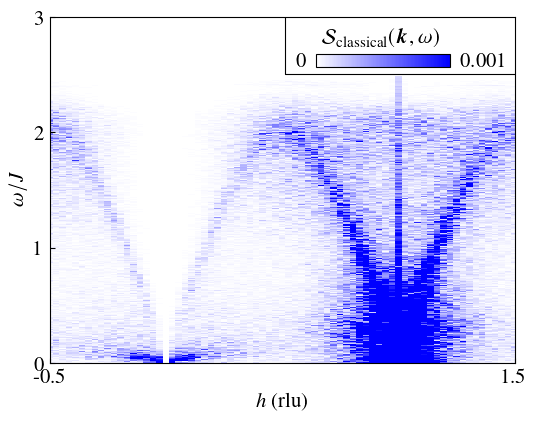

In [8]:
plt.rcParams['figure.figsize'] = (6, 4.5)
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['font.size'] = 15

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,newtxtext,newtxmath,bm}'
plt.rcParams['font.family'] = 'TeX Gyre Termes'

readfile = open("dump/DSSF_full.dat", "r")
contents = readfile.readlines()
readfile.close()

keys    = contents[1].split('\n')[0].split()
col_k   = keys.index('index')
col_E   = keys.index('omega')
col_Sxx = keys.index('Sxx')
col_Syy = keys.index('Syy')
col_Szz = keys.index('Szz')

k_list = []
E_list = []
for line in range(3, len(contents)):
    line_data = contents[line].split('\n')[0].split()
    if line_data[col_E] not in E_list:
        E_list.append(line_data[col_E])
    if line_data[col_k] not in k_list:
        k_list.append(line_data[col_k])
for i in range(0, len(k_list)):
    k_list[i] = float(k_list[i])
for i in range(0, len(E_list)):
    E_list[i] = float(E_list[i])

k_list = np.sort(k_list)
E_list = np.sort(E_list)
axis_X, axis_Y = np.meshgrid(k_list, E_list)
Intensity = np.zeros((len(E_list),len(k_list)))

for line in range(3, len(contents)):
    line_data = contents[line].split('\n')[0].split()
    k_idx = np.searchsorted(k_list, float(line_data[col_k]))
    E_idx = np.searchsorted(E_list, float(line_data[col_E]))
    if E_idx == 0:
        Intensity[E_idx][k_idx] = np.nan # cannot divide back by 0
    elif k_idx > 36 and E_idx > 395:
        Intensity[E_idx][k_idx] = np.nan # dig a hole in the plot for colorbar
    else:
        Intensity[E_idx][k_idx] = ( float(line_data[col_Sxx])
                                  + float(line_data[col_Syy])
                                  + float(line_data[col_Szz]) ) * 0.0005 / float(line_data[col_E])

fig, ax = plt.subplots()

cmap = colors.LinearSegmentedColormap.from_list("white_to_blue", [(1, 1, 1), (0, 0, 1)], N = 100)
imag = ax.pcolormesh(axis_X, axis_Y, Intensity, cmap = cmap, shading = "auto", vmin = 0, vmax = 0.001)

ax.set_xlim(k_list[0], k_list[-1])
ax.set_ylim(0.0, 3.0)
ax.set_xticks([k_list[0], k_list[-1]], ["-0.5", "1.5"])
ax.set_yticks([0, 1, 2, 3])
ax.set_xlabel(r"$h$ (rlu)")
ax.set_ylabel(r"$\omega/J$")
ax.tick_params(direction = 'in', color = 'black')

ax.text(8.5, 2.77, r'$\mathcal{S}_\text{classical}(\bm{k},\omega)$', fontsize = 15)
ax.text(7.7, 2.57, r'$0$', fontsize = 15)
ax.text(12.8, 2.57, r'$0.001$', fontsize = 15)

cax  = ax.inset_axes((8.3, 2.56, 4.2, 0.12), transform = ax.transData)
cbar = fig.colorbar(imag, cax = cax, orientation = "horizontal")
cbar.set_ticks([0, 0.001])
cbar.set_ticklabels(['', ''])
cbar.ax.tick_params(length = 0)
ax.plot([7.35, 7.35, k_list[-1]], [3.0, 2.5, 2.5], color = 'black', linewidth = 0.8)

plt.show()

### Note:
1. The paper PRL 101, 117207 (2008) used parallel tempering;
2. We haven't performed any averaging here (using different initial random seeds).

These two reasons likely explain why the statistics here is not as perfect as in that paper -- after all, the time cost of running this tutorial is only about a minute here.